<a href="https://colab.research.google.com/github/plthiyagu/AI-Engineering/blob/master/05-Statistical/Univariate_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# python outlier detection
!pip install pyod

     |████████████████████████████████| 112kB 3.9MB/s 
  Created wheel for pyod: filename=pyod-0.8.8-cp37-none-any.whl size=116967 sha256=0740c66d11029a3de4185c18f6915de5589e3087ac7aa8c7d4c056fdabba503a
  Stored in directory: /root/.cache/pip/wheels/54/dd/36/a12fa930455b7c38902f2dbf737175421ad30436e47ac5b24d
Successfully built pyod


In [ ]:
import warnings
import numpy as np
import pandas as pd
from pyod.models.mad import MAD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

pd.set_option('max.rows', 250)
warnings.filterwarnings('ignore')

## Import Data

In [ ]:
data_values = [['2021-05-1', 45000.0],
       ['2021-05-2', 70000.0],
       ['2021-05-3', 250000.0],
       ['2021-05-4', 70000.0],
       ['2021-05-5', 45000.0],
       ['2021-05-6', 55000.0],
       ['2021-05-7', 35000.0],
       ['2021-05-8', 60000.0],
       ['2021-05-9', 45000.0],
       ['2021-05-10', 25000.0],
       ['2021-05-11', 142936.0],
       ['2021-05-12', 138026.0],
       ['2021-05-13', 28347.0],
       ['2021-05-14', 40962.66],
       ['2021-05-15', 34543.0],
       ['2021-05-16', 40962.66],
       ['2021-05-17', 25207.0],
       ['2021-05-18', 37502.0],
       ['2021-05-19', 29589.0],
       ['2021-05-20', 78404.0],
       ['2021-05-21', 26593.0],
       ['2021-05-22', 123267.0],
       ['2021-05-23', 46880.0],
       ['2021-05-24', 65361.0],
       ['2021-05-25', 46042.0],
       ['2021-05-26', 48209.0],
       ['2021-05-27', 44461.0],
       ['2021-05-28', 90866.0],
       ['2021-05-29', 46886.0],
       ['2021-05-30', 33456.0],
       ['2021-05-31', 46251.0],
       ['2021-06-1', 29370.0],
       ['2021-06-2', 165620.0],
       ['2021-06-3', 20317.0]]
       
data = pd.DataFrame(data_values , columns=['date', 'amount'])
data.head()

,date,amount
0,2021-05-1,45000.0
1,2021-05-2,70000.0
2,2021-05-3,250000.0
3,2021-05-4,70000.0
4,2021-05-5,45000.0


In [ ]:
def fit_model(model, data, column='amount'):
    
    df = data.copy()
    data_to_predict = data[column].to_numpy().reshape(-1, 1)
    predictions = model.fit_predict(data_to_predict)
    df['Predictions'] = predictions
    
    return df

def plot_anomalies(df, x='date', y='amount'):

    # categories will be having values from 0 to n
    # for each values in 0 to n it is mapped in colormap
    categories = df['Predictions'].to_numpy()
    colormap = np.array(['g', 'r'])

    f = plt.figure(figsize=(12, 4))
    f = plt.scatter(df[x], df[y], c=colormap[categories])
    f = plt.xlabel(x)
    f = plt.ylabel(y)
    f = plt.xticks(rotation=90)
    plt.show()

## Inter Quartile Range

In [ ]:
def find_anomalies(value, lower_threshold, upper_threshold):
    
    if value < lower_threshold or value > upper_threshold:
        return 1
    else: return 0

def iqr_anomaly_detector(data, column='amount', threshold=1.1):
    
    df = data.copy()
    quartiles = dict(data[column].quantile([.25, .50, .75]))
    quartile_3, quartile_1 = quartiles[0.75], quartiles[0.25]
    iqr = quartile_3 - quartile_1

    lower_threshold = quartile_1 - (threshold * iqr)
    upper_threshold = quartile_3 + (threshold * iqr)

    print(f"Lower threshold: {lower_threshold}, \nUpper threshold: {upper_threshold}\n")
    
    df['Predictions'] = data[column].apply(find_anomalies, args=(lower_threshold, upper_threshold))
    return df

Lower threshold: -2944.050000000003, 
Upper threshold: 106441.55



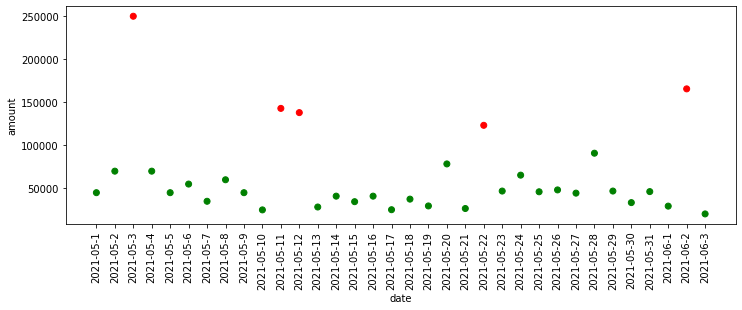

In [ ]:
iqr_df = iqr_anomaly_detector(data)
plot_anomalies(iqr_df)

## Isolation Forest

In [ ]:
def scale_anomaly_scores(s):
    """Changing (-0.5, 0.5) to (0, 1)"""
    a, b = (-0.5, 0.5), (1, 0)
    (a1, a2), (b1, b2) = a, b
    return (b1 + ((s - a1) * (b2 - b1) / (a2 - a1))) * 100

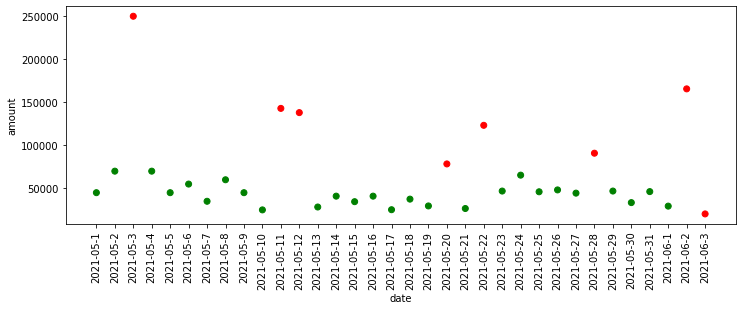

In [ ]:
iso_forest = IsolationForest(n_estimators=125)
iso_df = fit_model(iso_forest, data)
iso_df['Predictions'] = iso_df['Predictions'].map(lambda x: 1 if x==-1 else 0)
plot_anomalies(iso_df)

In [ ]:
iso_df.head()

,date,amount,Predictions
0,2021-05-1,45000.0,0
1,2021-05-2,70000.0,0
2,2021-05-3,250000.0,1
3,2021-05-4,70000.0,0
4,2021-05-5,45000.0,0


In [ ]:
univariate_data = data['amount'].to_numpy().reshape(-1, 1)
# These values range from -0.5 to 0.5
anomaly_scores = iso_forest.decision_function(univariate_data)
anomaly_scores


array([ 0.13891963,  0.03344293, -0.3012494 ,  0.03344293,  0.13891963,
        0.03497773,  0.08728813,  0.02132814,  0.13891963,  0.02695631,
       -0.06609441, -0.0590574 ,  0.05463206,  0.10478636,  0.08498873,
        0.10478636,  0.03696412,  0.07659118,  0.06875205, -0.03248365,
        0.03940844, -0.10531605,  0.13350039,  0.01125123,  0.13401883,
        0.09170439,  0.12055923, -0.07904102,  0.13350039,  0.07361183,
        0.13412699,  0.07237485, -0.1809977 , -0.10182862])

In [ ]:
iso_df['Anomaly Scores'] = anomaly_scores
iso_df.head()

,date,amount,Predictions,Anomaly Scores
0,2021-05-1,45000.0,0,0.138920
1,2021-05-2,70000.0,0,0.033443
2,2021-05-3,250000.0,1,-0.301249
3,2021-05-4,70000.0,0,0.033443
4,2021-05-5,45000.0,0,0.138920


In [ ]:
# Scale it between 1 and 100
scaled_scores = pd.Series(anomaly_scores).map(scale_anomaly_scores).to_numpy()

In [ ]:
iso_df['Scaled Scores'] = scaled_scores
iso_df.head()

,date,amount,Predictions,Anomaly Scores,Scaled Scores
0,2021-05-1,45000.0,0,0.138920,36.108037
1,2021-05-2,70000.0,0,0.033443,46.655707
2,2021-05-3,250000.0,1,-0.301249,80.124940
3,2021-05-4,70000.0,0,0.033443,46.655707
4,2021-05-5,45000.0,0,0.138920,36.108037


## MAD Model

In [ ]:
def get_anomaly_scores(model):
  anomaly_scores = model.decision_scores_
  threshold = model.threshold_
  return anomaly_scores, threshold

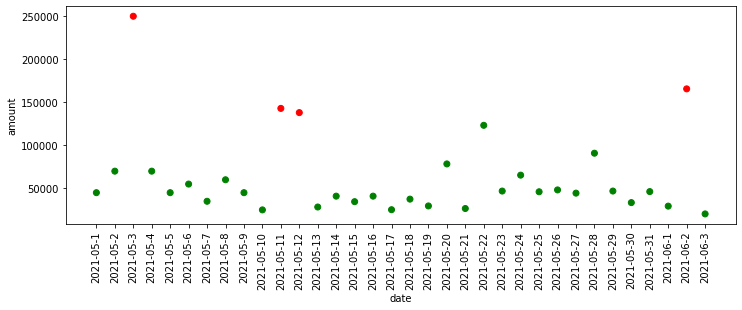

In [ ]:
"""Median Absolute Deviation"""
mad_model = MAD()
mad_df = fit_model(mad_model, data)
plot_anomalies(mad_df)

In [ ]:
anomaly_scores, threshold = get_anomaly_scores(mad_model)
print(f"Anomaly Scores: {anomaly_scores}, \nThreshold: {threshold}")

Anomaly Scores: [0.02311101 1.08586271 9.07047355 1.08586271 0.02311101 0.42047848
 0.4667005  0.64227322 0.02311101 0.91028999 4.32122702 4.10342458
 0.76182059 0.20220317 0.48697254 0.20220317 0.90110769 0.35571441
 0.70672678 1.45865532 0.83962619 3.44873085 0.06028381 0.88008155
 0.02311101 0.11923686 0.04702049 2.01145655 0.06054997 0.53519072
 0.03238203 0.71644139 5.32746542 1.11802295], 
Threshold: 3.5


In [ ]:
mad_df['Anomaly Scores'] = anomaly_scores
mad_df.head()

,date,amount,Predictions,Anomaly Scores
0,2021-05-1,45000.0,0,0.023111
1,2021-05-2,70000.0,0,1.085863
2,2021-05-3,250000.0,1,9.070474
3,2021-05-4,70000.0,0,1.085863
4,2021-05-5,45000.0,0,0.023111


## KNN Model

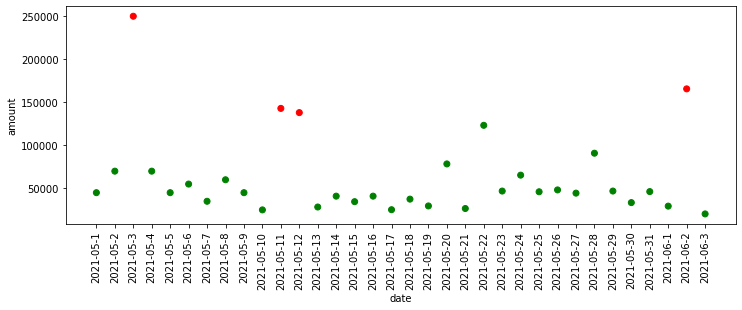

In [ ]:
"""KNN Based Outlier Detection"""
knn_model = KNN()
knn_df = fit_model(knn_model, data)
plot_anomalies(knn_df)

In [ ]:
anomaly_scores, threshold = get_anomaly_scores(knn_model)
print(f"Anomaly Scores: {anomaly_scores}, \nThreshold: {threshold}")

Anomaly Scores: [  1251.    15000.   159134.    15000.     1251.     8749.     5630.
  11791.     1251.     4589.    64532.    59622.     3347.     4037.34
   5173.     4037.34   4382.     4046.     4382.    18404.     2996.
  44863.     1880.    13043.     1042.     3209.     1790.    30866.
   1886.     4086.     1251.     4163.    84380.     9053.  ], 
Threshold: 55194.29999999999


In [ ]:
knn_df['Anomaly Scores'] = anomaly_scores
knn_df.head()

,date,amount,Predictions,Anomaly Scores
0,2021-05-1,45000.0,0,1251.0
1,2021-05-2,70000.0,0,15000.0
2,2021-05-3,250000.0,1,159134.0
3,2021-05-4,70000.0,0,15000.0
4,2021-05-5,45000.0,0,1251.0


In [ ]:
# Threshold computation
pd.Series(anomaly_scores).quantile(.90)

55194.29999999999

## Local Outlier Factor Model

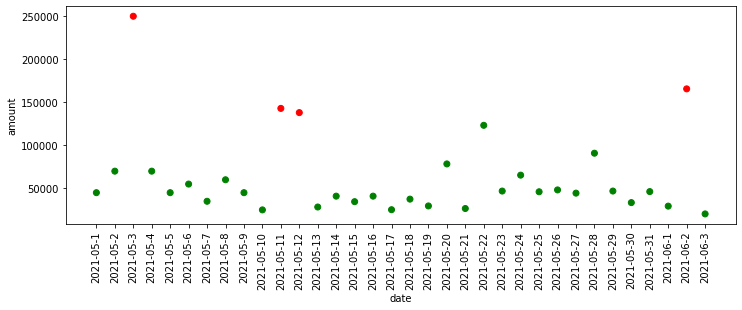

In [ ]:
"""LOF """
lof_model = LOF()
lof_df = fit_model(lof_model, data)
plot_anomalies(lof_df)

In [ ]:
anomaly_scores, threshold = get_anomaly_scores(lof_model)
print(f"Anomaly Scores: {anomaly_scores}, \nThreshold: {threshold}")

Anomaly Scores: [0.96943738 1.44663158 6.95138284 1.44663158 0.96943738 1.13613938
 0.98511861 1.19766155 0.96943738 1.02394401 3.68518031 3.53116118
 0.9835512  0.97372488 0.98379269 0.97372488 1.01856773 0.98716987
 0.98713539 1.72402355 0.99056951 3.06819412 0.98259654 1.30068672
 0.98039317 0.99370586 0.97097242 2.15395436 0.98257972 0.99829485
 0.98097905 0.98650339 4.33806271 1.16495666], 
Threshold: 3.3922710644189893


In [ ]:
# Threshold computation
pd.Series(anomaly_scores).quantile(.90)

3.3922710644189893

In [ ]:
# AutoEncoders 
# HBOS
# LSTM AutoEncoders